In [2]:
import sys
!{sys.executable} -m pip install pydub

  Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)

[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: /Users/elaineran/.pyenv/versions/3.10.14/bin/python -m pip install --upgrade pip


In [3]:
import pydub

In [4]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
import seaborn as sns
import matplotlib.pyplot as plt

2024-07-09 23:39:48.501525: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
notchloe = True

In [6]:
def not_chloe(b):
    if b is True:
        return "elaineran", "Desktop"
    else: 
        return "chloezhao", "summer 2024 project"

In [7]:
data_path = "/Users/"+not_chloe(notchloe)[0] + "/"+not_chloe(notchloe)[1]+"/summer-project/original spotify songs/"
metadata_path = "/Users/"+not_chloe(notchloe)[0] +"/"+not_chloe(notchloe)[1]+"/summer-project/top_50_2023.csv"

In [11]:
import os
import random
from pydub import AudioSegment

def cut_audio(input_file, output_path, file_name, i):
    # Load the audio file
    audio = AudioSegment.from_file(input_file)

    # Get the length of the audio in milliseconds
    audio_length = len(audio)

    # Generate random start time and ensure the cut is not longer than 20 seconds
    start_time = random.randint(0, audio_length)
    end_time = min(start_time + 20000, audio_length)  # Ensuring the cut does not exceed 20 seconds

    # Cut the audio segment
    cut_segment = audio[start_time:end_time]

    # Export the cut audio segment
    cut_segment.export(f"{output_path}/{file_name}_cut_{i}.wav", format="wav")

# Specify the directory containing the input audio files
input_folder = "/Users/"+not_chloe(notchloe)[0] + "/"+not_chloe(notchloe)[1]+"/summer-project/original spotify songs/"
# Specify the directory for output files
output_folder = "/Users/"+not_chloe(notchloe)[0] + "/"+not_chloe(notchloe)[1]+"/summer-project/spotify songs/"


# Create the output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# List all files in the input folder
input_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

for input_file in input_files:
    # Get the full path of the input file
    input_file_path = os.path.join(input_folder, input_file)
    # Get the base name of the file without extension
    file_name, _ = os.path.splitext(input_file)

    # Perform 10 cuts for each file
    for i in range(1, 4):
        cut_audio(input_file_path, output_folder, file_name, i)


In [3]:
import pandas as pd

# Load only specific columns from the CSV file into a DataFrame
spotify_2021_data = pd.read_csv('spotify_top50_2021.csv', usecols=['artist_name', 'track_name','key'])

spotify_2023_data = pd.read_csv('top_50_2023.csv', usecols=['artist_name', 'track_name','key'])

all_spotify_data = pd.concat([spotify_2021_data, spotify_2023_data], ignore_index=True)

all_spotify_data.to_csv('all_spotify_data.csv', index=False)

In [13]:
def load_data(data_path, metadata_path):
    features = []
    labels = []

    # Load the metadata
    metadata = pd.read_csv(metadata_path)

    # Iterate over each row in the metadata
    for index, row in metadata.iterrows():
        track_name = row['track_name']
        artist_name = row['artist_name']
        key_signature = row['key']

        # Assume there are 10 cuts for each track
        for cut in range(1, 11):
            # Construct the file path for each cut
            file_path = os.path.join(data_path, f"{track_name} - {artist_name}_cut_{cut}.wav")
            
            # Check if the file exists
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue

            # Load the audio file and resample it
            target_sr = 22050
            audio, sample_rate = librosa.load(file_path, sr=target_sr)

            # Check if the audio length is less than the default n_fft size
            if len(audio) < 2048:
                # Pad the audio file with zeros
                audio = np.pad(audio, (0, 2048 - len(audio)), mode='constant')

            # Extract MFCC features
            mfccs = librosa.feature.mfcc(y=audio, sr=target_sr, n_mfcc=40)
            mfccs_scaled = np.mean(mfccs.T, axis=0)

            # Append features and labels
            features.append(mfccs_scaled)
            labels.append(key_signature)

    return np.array(features), np.array(labels)

In [15]:
features, labels = load_data(data_path, metadata_path)


# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)


In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_onehot, test_size=0.2, random_state=42)


In [17]:
input_shape = (X_train.shape[1], 1)
model = Sequential()
model.add(Conv1D(64, 3, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(le.classes_), activation='softmax'))


2024-07-08 23:07:16.088507: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-08 23:07:16.089429: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-08 23:07:16.093518: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-08 23:07:16.096120: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-08 23:07:16.097754: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [20]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100


2024-07-08 23:07:22.921865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-08 23:07:23.035648: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


10/10 [==============================] - ETA: 0s - loss: 11.1232 - accuracy: 0.1219

2024-07-08 23:07:25.501373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 4s 94ms/step - loss: 11.1232 - accuracy: 0.1219 - val_loss: 5.5405 - val_accuracy: 0.1375
Epoch 2/100
10/10 [==============================] - 0s 32ms/step - loss: 7.9673 - accuracy: 0.1531 - val_loss: 2.7930 - val_accuracy: 0.1500
Epoch 3/100
10/10 [==============================] - 0s 27ms/step - loss: 4.6429 - accuracy: 0.2719 - val_loss: 2.3470 - val_accuracy: 0.3875
Epoch 4/100
10/10 [==============================] - 0s 27ms/step - loss: 3.7131 - accuracy: 0.3313 - val_loss: 2.4728 - val_accuracy: 0.3000
Epoch 5/100
10/10 [==============================] - 0s 28ms/step - loss: 2.7208 - accuracy: 0.3594 - val_loss: 1.8640 - val_accuracy: 0.4125
Epoch 6/100
10/10 [==============================] - 0s 27ms/step - loss: 2.7662 - accuracy: 0.4375 - val_loss: 2.1518 - val_accuracy: 0.4375
Epoch 7/100
10/10 [==============================] - 0s 27ms/step - loss: 2.5762 - accuracy: 0.4344 - val_loss: 2.0429 - val_accuracy: 0.4500
Epoch 8/100
10/10

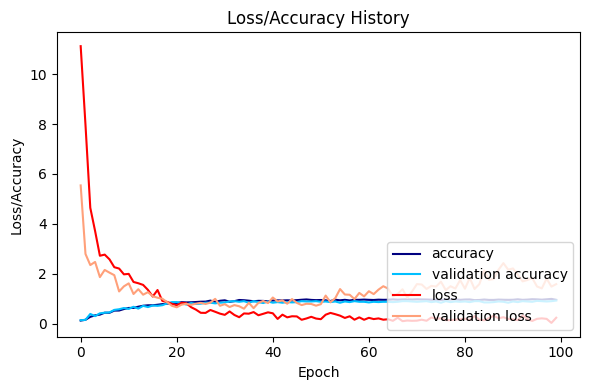

In [22]:
# plotting from history

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = list(range(len(loss)))

figsize = (6, 4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")


plots = plot1_loss + plot1_val_loss
labs = [plot.get_label() for plot in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History")
plt.tight_layout()
axis1.legend(loc='lower right')
#plt.savefig("/Users/chloezhao/summer 2024 project/summer-project/figures/Loss-Accuracy-Notes")
plt.show()

In [24]:
test_predictions = model.predict(X_test)

2024-07-08 23:11:45.089040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 33ms/step


In [25]:
predicted_class_indices = np.argmax(test_predictions, axis=1)
predicted_classes = le.inverse_transform(predicted_class_indices)
print(predicted_classes)

[ 8 10  9  0 11 11  5 11  7 11 10  8  6  1  0  6 11  0  8  4  1  8  4 11
 10  4  4  1  7  4  4  3  7  1  8  4  4  1  5  8  4  0  1  1 11  4  8  0
  1  0  6  5  9  1  0  9  1  0  9  5 11  6  6 11  6  9  8  7  4  1  5  8
 10  6  4  1  1  8  0  1]


In [26]:
y_true = np.argmax(y_test, axis=1)
true_classes = le.inverse_transform(y_true)
print(true_classes)

[ 7 10  9  0 11 11  5 11  7 11 10  8  0  1  0  6 11  0  8  4  1  8  4 11
 10  4  4  1  7  4  4  3  7  0  8  4  4  1  5  8  4  0  1  1 11  4  8  0
  1  0  6  5  9  1  0  9  1  0  9  5 11  6  6  1  4  9  8  7  4  1  5  8
 10  6  4  1  1  8  0 10]


In [27]:
unique_labels = np.unique(np.concatenate([y_true, predicted_class_indices]))


# Calculate accuracy
accuracy = accuracy_score(y_true, predicted_class_indices)
print("Accuracy:", accuracy)


# Generate a classification report
#print(classification_report(y_true, predicted_class_indices, labels=unique_labels, target_names=le.inverse_transform(unique_labels)))


# Confusion matrix
cm = confusion_matrix(y_true, predicted_class_indices)
print("Confusion Matrix:\n", cm)

Accuracy: 0.925
Confusion Matrix:
 [[ 9  1  0  0  0  1  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  0  0  1]
 [ 0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0 12  0  1  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  1  0  0  0]
 [ 0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  0  0]
 [ 0  1  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  0  0  8]]


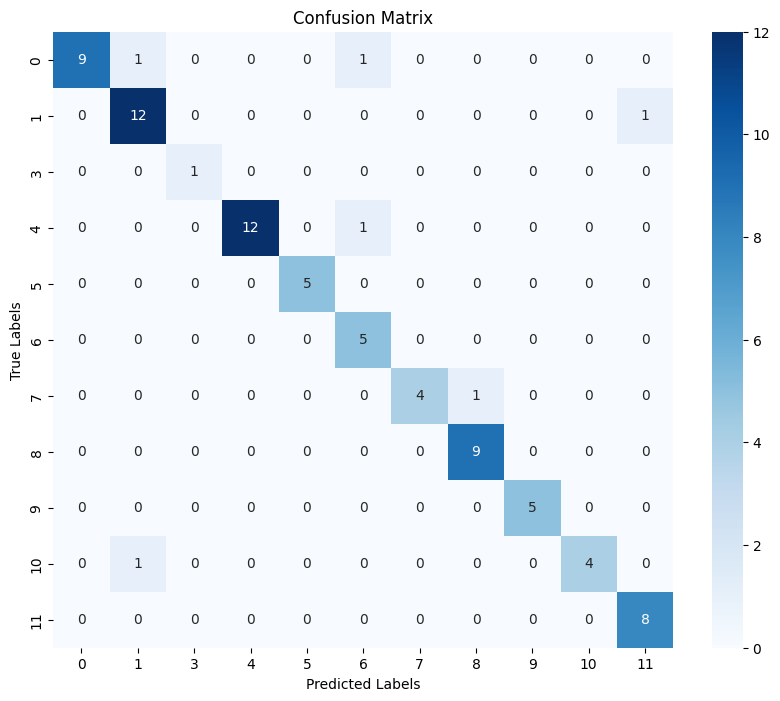

In [29]:


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("/Users/"+not_chloe(notchloe)[0] + "/"+not_chloe(notchloe)[1]+"/summer-project/figures/Confusion-Matrix-Notes")
plt.show()
